In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import matplotlib as plt
import riskfolio.Reports as rp
import pypfopt.efficient_frontier as eff

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import expected_returns
from pypfopt import objective_functions
from scipy.stats import norm


from finquant.portfolio import *
from finquant.moving_average import compute_ma, ema

import quantstats as qs

In [2]:
df_health = pd.read_csv('tick_score_health.csv')
df_tech = pd.read_csv('tick_score_tech.csv')
df_durable = pd.read_csv('tick_score_durable.csv')
df_nondurable = pd.read_csv('tick_score_nondurable.csv')
df_capital = pd.read_csv('tick_score_capital.csv')
df_transport = pd.read_csv('tick_score_transport.csv')
df_util = pd.read_csv('tick_score_util.csv')
df_services = pd.read_csv('tick_score_services.csv')
df_energy = pd.read_csv('tick_score_energy.csv')
df_finance = pd.read_csv('tick_score_finance.csv')
df_basics = pd.read_csv('tick_score_basics.csv')


frames = [df_finance, df_capital, df_durable, df_energy, df_health, df_nondurable, df_services, df_tech, df_services, df_util, df_basics]
df = pd.concat(frames)
df = df.drop_duplicates(subset=['Unnamed: 0'], keep='last')
df = df.set_index("Unnamed: 0")

percentile = np.percentile(df['Score'], 90)
mu, std = norm.fit(df['Score'])
roc = std / 3
#aplus = df[df['Score'] > mu + (roc*4)]
aplus = df[df['Score'] > mu + (roc*4)]
tickers = list(aplus.index)

In [3]:
start = "2016-01-01"
end = "2020-12-30"

# Tickers of assets
assets = tickers
assets.sort()

In [4]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  48 of 48 completed


In [5]:
Y = data[assets].pct_change().dropna()

In [6]:
S = risk_models.CovarianceShrinkage(data[assets]).ledoit_wolf()

In [7]:
port = pf.Portfolio(returns = Y)
port.assets_stats(method_mu= 'hist', method_cov= 'hist') 

In [8]:
model='BL' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' 
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False 
rf = 0.05
l = 0 
points = 50

In [9]:
market_data = yf.download("^GSPC", start = start, end = end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  1 of 1 completed


In [10]:
delta = black_litterman.market_implied_risk_aversion(market_data)

In [11]:
mcaps = {}
for t in assets:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]

In [12]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

In [13]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views={})

In [23]:
ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

eff.risk_free_rate=0.36
eff.freq=1260
ef = eff.EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.max_sharpe()
#ef.min_volatility()
ef.portfolio_performance(verbose=True)
weights = ef.clean_weights()
weights = pd.Series(weights)
display(weights)

Expected annual return: 12.7%
Annual volatility: 21.7%
Sharpe Ratio: 0.49


ABBV    0.03512
APD     0.02843
AZO     0.00619
BA      0.06467
BCE     0.00072
BEN     0.02369
BKNG    0.02853
BTI     0.02404
CL      0.01497
CLX     0.00000
CMI     0.01396
D       0.01987
DEO     0.01438
DPZ     0.00000
DVN     0.02206
EL      0.02873
EMR     0.02621
EOG     0.00717
FANG    0.00604
GILD    0.00654
HCA     0.02579
HON     0.03270
IDXX    0.01911
IFF     0.01938
IHG     0.02237
IQV     0.02899
JHX     0.02460
KDP     0.00000
KEP     0.00020
KMB     0.00958
KO      0.02604
LIN     0.02956
LNG     0.00000
LYB     0.03475
MCO     0.04556
MDLZ    0.03209
MTD     0.01672
NGG     0.01298
OXY     0.02355
PEP     0.03473
PM      0.03870
PPG     0.01654
PSX     0.02488
SPG     0.02961
SPGI    0.03303
TRV     0.01980
VRSN    0.01715
YUM     0.01028
dtype: float64

In [15]:
ef.portfolio_performance(verbose=True, risk_free_rate=0.36)

Expected annual return: 12.7%
Annual volatility: 21.7%
Sharpe Ratio: 0.49


C:\Apps\Anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:404: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.12704427585591838, 0.21743794469944597, 0.49229804854842857)

In [16]:
W1 = pd.DataFrame(weights, index = assets, columns = ['Black Lit'])

In [17]:
W1_dup = W1.reset_index()
W1_dup.columns = ["Name", "Allocation"]
df_pf = build_portfolio(names=list(W1.index), start_date = start, end_date = end, data_api="yfinance", pf_allocation = W1_dup)
df_pf.freq = 1260
df_pf.risk_free_rate = 0.36
display(df_pf.comp_sharpe())
df_pf.properties()

[*********************100%***********************]  48 of 48 completed


0.9229296357162726

----------------------------------------------------------------------
Stocks: ABBV, APD, AZO, BA, BCE, BEN, BKNG, BTI, CL, CLX, CMI, D, DEO, DPZ, DVN, EL, EMR, EOG, FANG, GILD, HCA, HON, IDXX, IFF, IHG, IQV, JHX, KDP, KEP, KMB, KO, LIN, LNG, LYB, MCO, MDLZ, MTD, NGG, OXY, PEP, PM, PPG, PSX, SPG, SPGI, TRV, VRSN, YUM
Time window/frequency: 1260
Risk free rate: 0.36
Portfolio Expected Return: 0.806
Portfolio Volatility: 0.483
Portfolio Sharpe Ratio: 0.923

Skewness:
       ABBV       APD       AZO        BA       BCE       BEN      BKNG  \
0 -0.018119  0.848999  0.331902  0.033088  0.211962 -0.506981 -0.643807   

        BTI        CL       CLX  ...       OXY       PEP        PM       PPG  \
0  0.162431  0.941796  1.187317  ... -0.986038  0.424476  0.577613  0.897645   

        PSX       SPG      SPGI       TRV      VRSN       YUM  
0  0.236512 -1.370431  0.571176  0.100396  0.107088  0.033256  

[1 rows x 48 columns]

Kurtosis:
       ABBV       APD       AZO        BA       BCE     

[*********************100%***********************]  4 of 4 completed


PRWAX    66.169272
SWPPX    83.268981
WFIVX    42.547109
^GSPC    85.179811
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-22  164.995096  181.306302  143.061102  183.203320
2020-12-23  165.092945  181.435005  143.232436  183.339955
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811

[1256 rows x 4 columns]

Date
2016-01-05    100.228467
2016-01-06     98.709982
2016-01-07     96.126594
2016-01-08     95.046694
2016-01-11     95.035830
                 ...    
2020-12-22    194.384911
2020-12-23    195.834704
2020-12-24    196.129197
2020-12-28    196.585984
2020-12-29    196.621083
Length: 1256, dtype: float64


<AxesSubplot:xlabel='Date'>

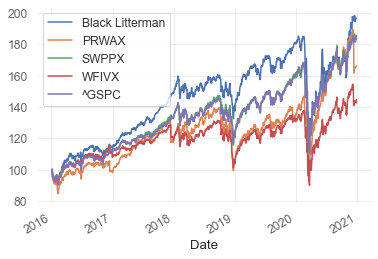

In [18]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end=end, threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[assets].pct_change().fillna(0)[1:]
for tick in W1.index:
    Y_cum.loc[:,tick] *= W1.loc[tick].values
port_ret = Y_cum.sum(axis=1)
Y_cum_ret = (port_ret + 1).cumprod()
Y_cum_ret *= 100
print(Y_cum_ret)



pfcr = pd.DataFrame(Y_cum_ret)
pfcr.columns = ["Black Litterman"]
newdf = pfcr.join(compare_port)

newdf.plot()

In [24]:
qs.stats.sharpe(port_ret, rf=0.36, periods=1260)

1.0115771772111346

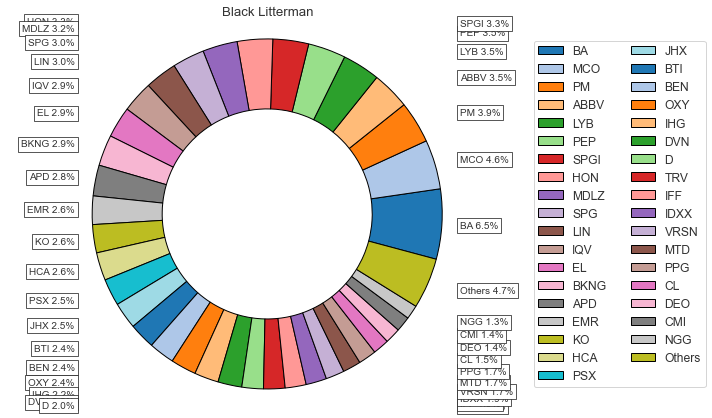

In [20]:
ax = plf.plot_pie(w=W1, title='Black Litterman', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


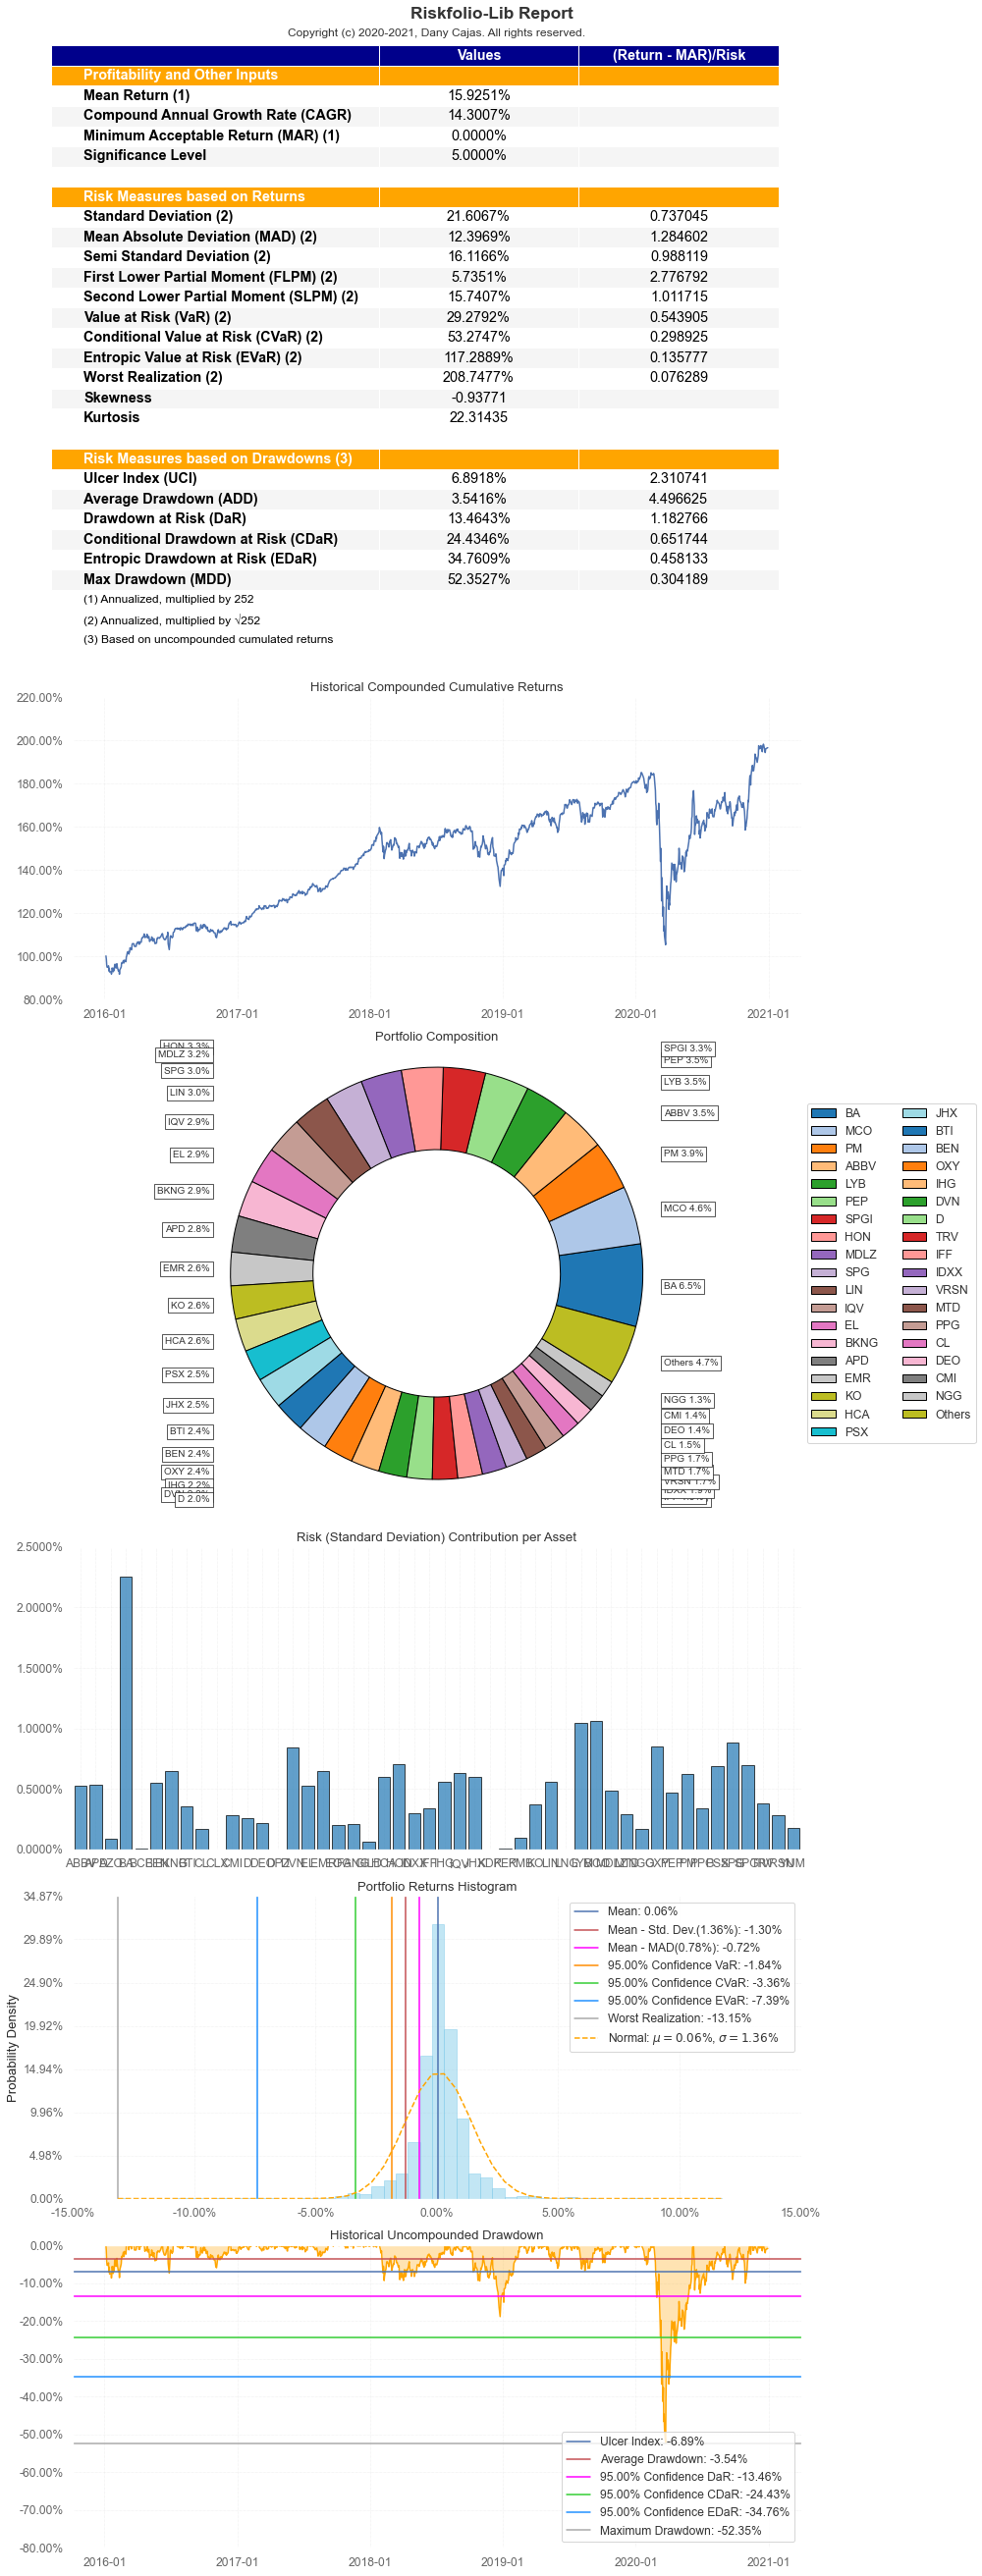

In [21]:
ax_report = rp.jupyter_report(Y, w=W1, rm='MV', rf=0, alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)